In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import re 
import numpy as np 
import pandas as pd 
import pprint 

from sklearn.feature_extraction.text import CountVectorizer

In [10]:
def get_summary(f,sep='\t'):
    df = pd.read_csv(f,sep=sep)
    label_cols = df.columns[1:]
    df['multi_label'] = df[label_cols].sum(axis=1)
    df['multi_label'] = df['multi_label'].apply(lambda x: 1 if x > 1 else 0)
    df['total_count'] = 1
    num_cols = df.columns[1:]
    df_sum = df[num_cols].sum(axis=0)
    return df_sum.to_dict()

In [5]:
# https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb
def get_top_words(f,count=5,pre_process=False):
    def clean_up(s):
        s = s.lower()
        s = s.lower()
        s = re.sub('\d+', 'NUM',s)
        s = re.sub('[^(a-zNUM)]', ' ',s)
        return ' '.join(s.split())

    df = pd.read_csv(f,sep='\t')
    df = df.rename(columns={"Text":"text"})
    label_cols = df.columns[1:]
    bow = [' '.join(df[df[lbl] == 1].text.to_list()) for lbl in label_cols]
    if pre_process:
        bow = [clean_up(s) for s in bow]
    cv = CountVectorizer(stop_words = 'english')
    X = cv.fit_transform(bow)
    X = X.toarray()
    bow_df = pd.DataFrame(X, columns=cv.get_feature_names())
#    bow_df = bow_df.apply(lambda x: np.where (x <= 3,np.nan,x))
    bow_df.index = label_cols

    bow_trans_df = bow_df.apply(lambda x: (x+1)/ (bow_df.loc[x.name].sum()+1),axis=1)
    results = {lbl:[] for lbl in label_cols}
    for lbl in label_cols:
        feat_s = bow_df[bow_df.index != lbl].sum() + 1
        feat_s_all = np.sum(bow_df[bow_df.index != lbl].sum())
        
        tot = feat_s/ feat_s_all 
        row = bow_trans_df.loc[lbl] / tot
        row = pd.DataFrame(row,columns=['log_odds'])
        # row = row[(row.log_odds > 3) & (row.log_odds < 300)]
        row = row.T
        row_cols = row.columns
        row_arr = row.to_numpy()
        max_arr = np.flip(np.argsort(row_arr,axis=1)[:,-count:],axis=1)
        topn = row.iloc[:,max_arr[0]] 
        top_words = ['{}:{:0.1f}'.format(w,c) for w,c in zip(list(topn.columns),list(topn.iloc[0]))] 
        results[lbl] = top_words
              
    return results

In [13]:
all_train = {}
all_train['GO'] = get_summary('./data/final_ekman/goemotions_train.tsv')
all_train['SEM'] = get_summary('./data/final_ekman/semeval_train.tsv')
all_train['FR'] = get_summary('./data/final_ekman/friends_train.tsv')
all_train['TALES'] = get_summary('./data/final_ekman/tales_train.tsv')
df_summ = pd.DataFrame(all_train)

<AxesSubplot:>

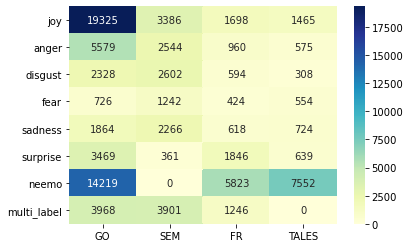

In [14]:
sns.heatmap(data=df_summ[df_summ.index != 'total_count'], annot=True, cmap='YlGnBu', fmt='d')

In [16]:
all_dev = {}
all_dev['GO'] = get_summary('./data/final_ekman/goemotions_dev.tsv')
all_dev['SEM'] = get_summary('./data/final_ekman/semeval_dev.tsv')
all_dev['FR'] = get_summary('./data/final_ekman/friends_dev.tsv')
all_dev['TALES'] = get_summary('./data/final_ekman/tales_dev.tsv')
df_dev = pd.DataFrame(all_dev)

<AxesSubplot:>

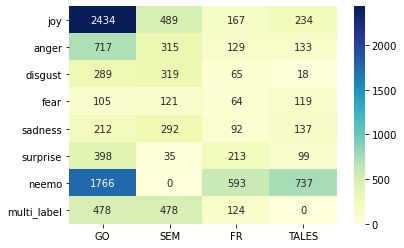

In [17]:
sns.heatmap(data=df_dev[df_dev.index != 'total_count'], annot=True, cmap='YlGnBu', fmt='d')

In [8]:

words = {}
topwords = get_top_words('./data/final_ekman/tales_train.tsv')
words['TALES']= topwords
topwords = get_top_words('./data/final_ekman/tales_train.tsv',pre_process=True)
words['TALES_CLEAN']= topwords
topwords = get_top_words('./data/final_ekman/goemotions_train.tsv')
words['GO']= topwords
topwords = get_top_words('./data/final_ekman/goemotions_train.tsv',pre_process=True)
words['GO_CLEAN']= topwords
topwords = get_top_words('./data/final_ekman/semeval_train.tsv')
words['SEM']= topwords
topwords = get_top_words('./data/final_ekman/semeval_train.tsv',pre_process=True)
words['SEM_CLEAN']= topwords
topwords = get_top_words('./data/final_ekman/friends_train.tsv')
words['FR']= topwords
topwords = get_top_words('./data/final_ekman/friends_train.tsv',pre_process=True)
words['FR_CLEAN']= topwords
pprint.pprint(words)

{'FR': {'anger': ['punk:33.6',
                  'wesley:33.6',
                  'angry:33.6',
                  'charge:33.6',
                  'suggestion:33.6'],
        'disgust': ['ew:181.2',
                    'eww:60.4',
                    'boobs:60.4',
                    'violated:45.3',
                    'moms:45.3'],
        'fear': ['wa:72.5',
                 'vulnerability:48.4',
                 'terrified:48.4',
                 'hangs:48.4',
                 'weights:48.4'],
        'joy': ['yay:58.1',
                'incredible:40.7',
                'woo:34.8',
                'soo:34.8',
                'dum:34.8'],
        'neemo': ['30:12.1', 'la:9.9', 'nope:7.7', 'tall:7.7', 'ice:7.7'],
        'sadness': ['cramp:59.0',
                    '28:44.2',
                    'hopes:44.2',
                    'knowing:44.2',
                    'ye:44.2'],
        'surprise': ['whoa:37.4',
                     'oww:27.0',
                     'contraction:27.0',

In [9]:
df_words = pd.DataFrame(words)
with pd.option_context("max_colwidth", 1000):
    print (df_words.to_latex('./data/results/topwords.tex'))

None
